# Classification of Brain Tumors using Convolutional Neural Networks #

In this notebook, I implement neural network models for the classification of brain tumors. The CNNs provide better accuracy for image classification. Here, I implement both ANNs as an initial trial, and CNNs for the final implementation, and try dropout layers to reduce overfitting and improve the accuracy of prediction of the test data.

## Exploratory data analysis ##

In this section, the datasets are collected, preprocessed and visualized to gain an understanding of the data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The train and test datasets of brain tumor images are read and stored below.

In [2]:
# Import libraries, unzip image data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns

zip_path = r"/content/drive/My Drive/DS/Data_Set_BrainTumor.zip"
!cp "{zip_path}" .
!unzip -q Data_Set_BrainTumor.zip
!rm Data_Set_BrainTumor.zip

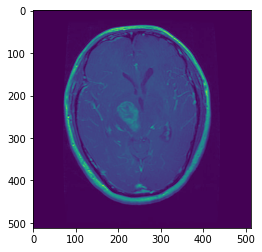

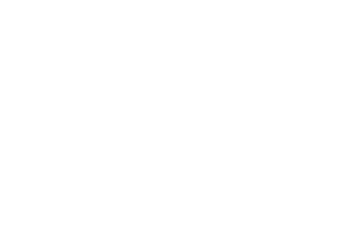

In [3]:
#Display one image from training set

# Using Contrast Limited Adaptive Histogram Equalization
#clahe = cv2.createCLAHE()
TRAIN_DATADIR = "./Data Set Brain Tumor/Training"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
for category in CATEGORIES:
    path = os.path.join(TRAIN_DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        #img_array = clahe.apply(img_array) # commented out as it did not improve prediction
        plt.imshow(img_array)
        plt.show()
        plt.axis("off")
        break
    break

(-0.5, 149.5, 149.5, -0.5)

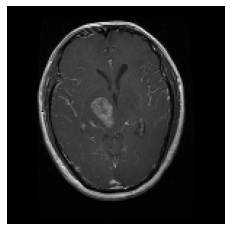

In [4]:
#Reshaping image to 150X150
IMG_SIZE = 150
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))    
plt.imshow(new_array,cmap = "gray")
plt.axis("off")

In [5]:
# Function to create image data sets
# Reading the images from the path and labeling them into the given categories

def create_data(DATADIR):
    dataset = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                #img_array = clahe.apply(img_array) # commented out as it did not improve prediction
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                # normalization by minmax scaling, commented out as it did not improve results
                # normalization will be done by scaling by 255 later
                #new_array = (new_array - np.min(new_array))/(np.max(new_array)-np.min(new_array))
                dataset.append([new_array,class_num])
            except:
                pass
    return dataset

In [6]:
#Storing and reshaping all the training images

training_data = create_data(TRAIN_DATADIR)

In [7]:
#Training set, store X_train and y_train, normalize and reshape X_train

X_train = []
y_train = []
for features,label in training_data:
    X_train.append(features)
    y_train.append(label)
X_train = np.array(X_train).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X_train.shape)
# normalization
X_train = X_train/255.0  
X_train = X_train.reshape(-1,IMG_SIZE,IMG_SIZE,1)

(2881, 150, 150)


Load the test images in the same way

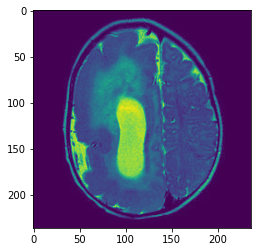

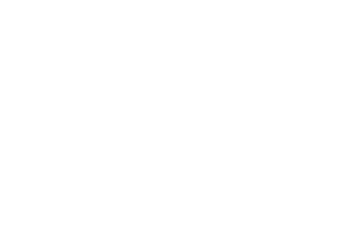

In [8]:
# Load the test data
# Display the first image

TEST_DATADIR = "./Data Set Brain Tumor/Testing"

for category in CATEGORIES:
  path = os.path.join(TEST_DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    #img_array = clahe.apply(img_array) # commented out as it did not improve prediction
    plt.imshow(img_array)
    plt.show()
    plt.axis("off")
    break
  break
  

(-0.5, 149.5, 149.5, -0.5)

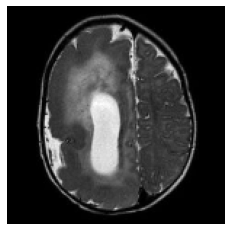

In [9]:
#Reshaping the test image to 150X150

test_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))    
plt.imshow(test_array,cmap = "gray")
plt.axis("off")


In [10]:
#Storing and reshaping the test images
test_data = create_data(TEST_DATADIR)


In [11]:
#Test set, store X_test and y_test, normalize and reshape X_test

X_test = []
y_test = []

for feature, label in test_data:
  X_test.append(feature)
  y_test.append(label)

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE)
# normalization
X_test = X_test/255.0
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(X_test.shape)

(402, 150, 150, 1)


In [12]:
# Import libraries

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.layers import Input, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses, optimizers


In [13]:
# One hot encoding of target variables

y_train_e = to_categorical(y_train)
y_test_e = to_categorical(y_test)

In [14]:
# Target train and test data size

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train.shape, y_train_e.shape, y_test.shape, y_test_e.shape


((2881,), (2881, 4), (402,), (402, 4))

In [15]:
# Train and test data size

X_train.shape, X_test.shape

((2881, 150, 150, 1), (402, 150, 150, 1))

In [16]:
# Size of training data set by category

train_key, train_num = np.unique(y_train, return_counts=True)
print(train_key, train_num)

[0 1 2 3] [829 830 395 827]


In [17]:
# List of Tumor category names 
Cat_names = [name.split('_')[0].capitalize() for name in CATEGORIES]
Cat_names[Cat_names.index('No')] = 'None'

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


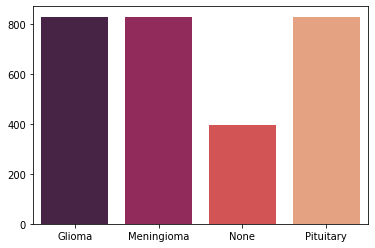

In [18]:
# Barplot of training data by category

ax = sns.barplot(train_key, train_num, palette='rocket')
ax.set_xticklabels(Cat_names)
ax.set_yticks(np.arange(0,1000,200))

There are 4 categories of images (glioma_tumor, meningioma_tumor, no_tumor, and pituitary_tumor), and 829, 830, 395 and 827 images in each category in the training set. There are 2881 images in the training set in total.

In [19]:
# Size of test data set by category

test_key, test_num = np.unique(y_test, return_counts=True)
print(test_key, test_num)

[0 1 2 3] [100 115 113  74]


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


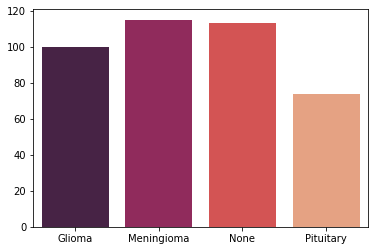

In [20]:
# Barplot of test data by category

ax = sns.barplot(test_key, test_num, palette='rocket')
ax.set_xticklabels(Cat_names)
plt.show()

There are 100, 115, 113 and 74 images of each category (glioma_tumor, meningioma_tumor, no_tumor, and pituitary_tumor) in the test set. There are 402 images in all in the test set.

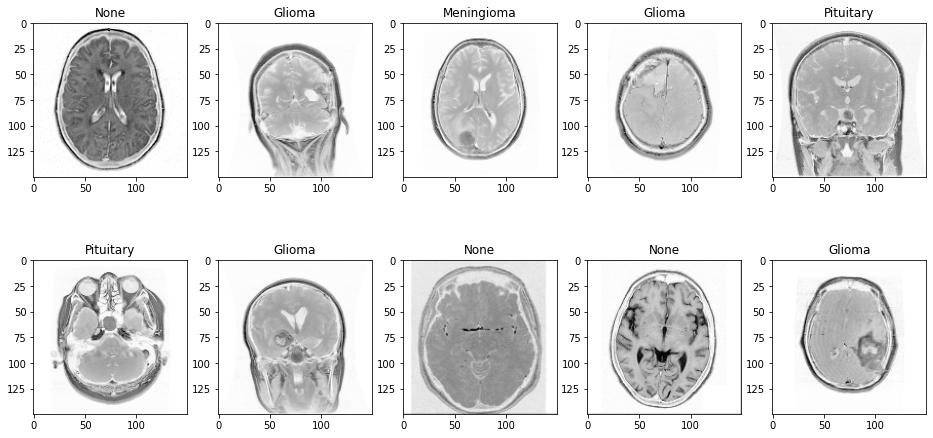

In [21]:
# Plot ten random training images

ind = np.random.randint(0, X_train.shape[0], 10)
plt.figure(figsize=(16,8))
for i, idx in enumerate(ind):
  plt.subplot(2, 5, i+1)
  plt.imshow(cv2.resize(X_train[idx], (IMG_SIZE, IMG_SIZE)), plt.cm.binary)
  plt.title(Cat_names[y_train[idx]])

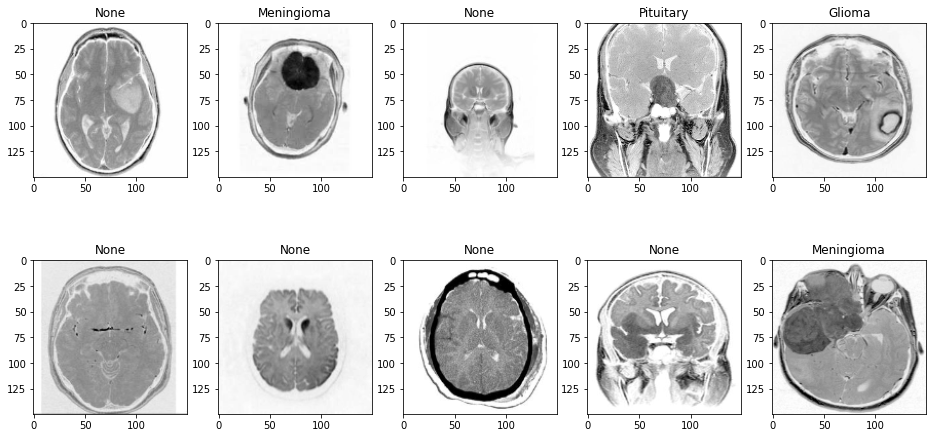

In [22]:
# Plot 10 random test images

ind = np.random.randint(0, X_test.shape[0], 10)
plt.figure(figsize=(16,8))
for i, idx in enumerate(ind):
  plt.subplot(2, 5, i+1)
  plt.imshow(cv2.resize(X_test[idx], (IMG_SIZE, IMG_SIZE)), plt.cm.binary)
  plt.title(Cat_names[y_test[idx]])

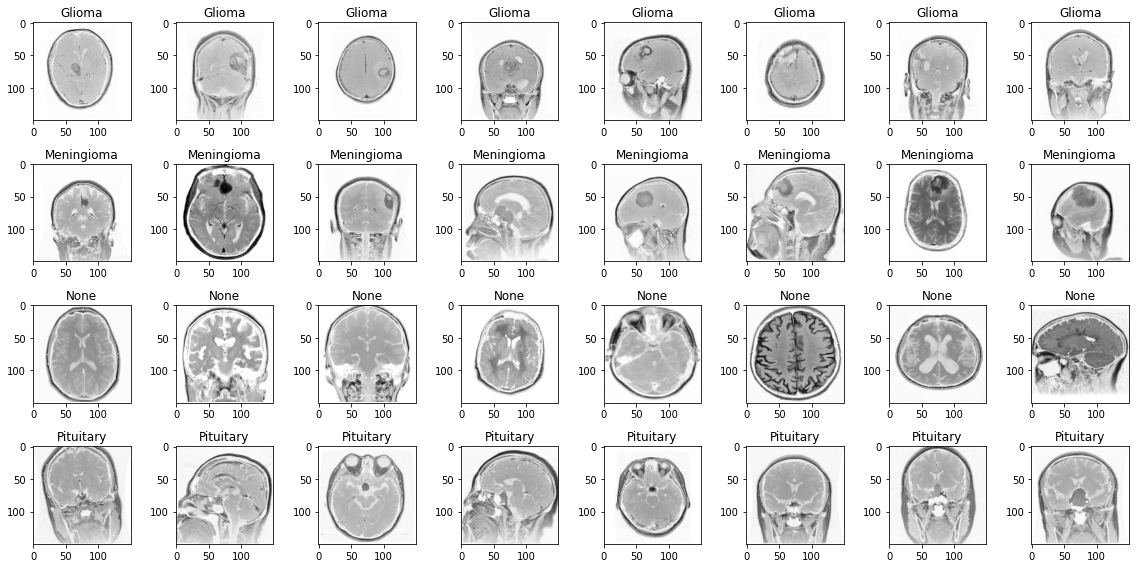

In [23]:
# Plot images of each tumor category in the training set (or test set), to visualize the data by category

import itertools
# Number of images to plot in each category
nimages = 8
# Make a dataframe with images and categories
df = pd.DataFrame()
df['Images'] = [cv2.resize(X_train[idx], (IMG_SIZE, IMG_SIZE)) 
                for idx in range(X_train.shape[0])]
df['Category'] = [Cat_names[y_train[idx]] for idx in range(0, y_train.shape[0])]
# Plot
plt.figure(figsize=(16,8))
for i, j in itertools.product(range(len(Cat_names)), range(nimages)):
  img = df[df['Category']==Cat_names[i]]['Images']
  plt.subplot(4, nimages, i*nimages+j+1)
  plt.imshow(img.iloc[j], plt.cm.binary)
  plt.title(Cat_names[i])
plt.tight_layout()

In [24]:
# Define variables for modeling

# Number of categories
num_classes = len(CATEGORIES)
# Input shape
in_shape = X_train.shape[1:]
# Learning rate 
lr = 0.001

In [25]:
# Fix the seed for reproducibility, for comparing different models and hyperparameters
seed = 7
np.random.seed(seed)

First I try vanilla neural network models. CNN works better for the image classification in this case, but I implement the simple neural network models as a trial to check how much accuracy can be obtained.

## ANN models ##

In [ ]:
# First try a vanilla neural network model
# Flatten the input, then use Dense layers with relu acivation, 
# and the final Dense layer with softmax activation

def vanillaNN(in_shape, layers, num_classes, lr):
  i = Input(shape=in_shape)
  x = Flatten()(i)

  for nlayer, nunits in enumerate(layers):
    x = Dense(nunits)(x)
    x = Activation('relu')(x)

  x = Dense(num_classes)(x)
  x = Activation('softmax')(x)

  ann_model = Model(inputs=i, outputs=x)
  optimizer = optimizers.Adam(lr=lr)
  ann_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return ann_model
  

In [ ]:
# ANN with 16 and 32 units in dense layers

model_ann1 = vanillaNN(in_shape, [16,32], num_classes, lr)
model_ann1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 22500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                360016    
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132 

In [ ]:
# Image augmentation is tried here, Since the images vary in zoom and brightness.
# Randomly generate images by brightness adjustment and zoom adjustment during training, 
# to make the classifier more robust
# Using brightness_range and zoom_range worsened the validation accuracy
# Flipping or rotation are not meaningful in this context, 
# as the images are top, side, front, or back views of the skull

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(brightness_range=[0.9,1.1],
                             zoom_range=[0.9,1.1],
                             validation_split=0.2)

train_gen = datagen.flow(X_train, y_train_e, batch_size=128, 
                         shuffle=True, seed=42, subset='training')
val_gen = datagen.flow(X_train, y_train_e, batch_size=128, seed=42, subset='validation')

STEP_SIZE_TRAIN = train_gen.n//128
STEP_SIZE_VAL = val_gen.n//128

In [ ]:
train_gen.n, val_gen.n # Size of training and validation data

(2305, 576)

In [ ]:
# Results with image augmentation

history_model_ann1 = model_ann1.fit_generator(train_gen, validation_data=val_gen, 
                            steps_per_epoch=STEP_SIZE_TRAIN, 
                            validation_steps=STEP_SIZE_VAL,
                            epochs=40)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
18/18 [==============================] - 6s 339ms/step - loss: 164.9837 - accuracy: 0.2542 - val_loss: 5.8518 - val_accuracy: 0.6973
Epoch 2/40
18/18 [==============================] - 5s 298ms/step - loss: 32.0749 - accuracy: 0.3600 - val_loss: 78.0937 - val_accuracy: 0.0000e+00
Epoch 3/40
18/18 [==============================] - 5s 302ms/step - loss: 16.4185 - accuracy: 0.4992 - val_loss: 58.6629 - val_accuracy: 0.0000e+00
Epoch 4/40
18/18 [==============================] - 5s 298ms/step - loss: 10.6099 - accuracy: 0.4769 - val_loss: 4.0100 - val_accuracy: 0.4746
Epoch 5/40
18/18 [==============================] - 5s 307ms/step - loss: 5.3218 - accuracy: 0.4667 - val_loss: 8.5985 - val_accuracy: 0.1484
Epoch 6/40
18/18 [==============================] - 5s 307ms/step - loss: 3.6286 - accuracy: 0.5246 - val_loss: 2.4991 - val_accuracy: 0.2207
Epoch 7/40
18/18 [==============================] - 5s 302ms/step - loss: 27.2369 - accuracy: 0.3236 - val_loss: 31.9389 - val_accura

The vanilla neural network model with image augmentation performs poorly. Below, the neural network model is tried without image augmentation.

In [ ]:
# Try vanilla NN without image generator
# 16 and 32 units in dense layers

model_ann2 = vanillaNN(in_shape, [16,32], num_classes, lr)
model_ann2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 22500)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                360016    
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 132 

In [ ]:
# A validation split of 0.2 and batch size of 512 are used.

history_model_ann2 = model_ann2.fit(X_train, y_train_e, 
                                    validation_split=0.2, verbose=1, 
                                    batch_size=512, epochs=40)

Epoch 1/40
5/5 [==============================] - 1s 72ms/step - loss: 1.3409 - accuracy: 0.3472 - val_loss: 1.6476 - val_accuracy: 0.1785
Epoch 2/40
5/5 [==============================] - 0s 30ms/step - loss: 1.1256 - accuracy: 0.4816 - val_loss: 1.5721 - val_accuracy: 0.2756
Epoch 3/40
5/5 [==============================] - 0s 29ms/step - loss: 1.0226 - accuracy: 0.5588 - val_loss: 1.5680 - val_accuracy: 0.3449
Epoch 4/40
5/5 [==============================] - 2s 391ms/step - loss: 0.9636 - accuracy: 0.5767 - val_loss: 1.0510 - val_accuracy: 0.7071
Epoch 5/40
5/5 [==============================] - 0s 30ms/step - loss: 0.8863 - accuracy: 0.6407 - val_loss: 1.1600 - val_accuracy: 0.5789
Epoch 6/40
5/5 [==============================] - 0s 31ms/step - loss: 0.8237 - accuracy: 0.6752 - val_loss: 0.9691 - val_accuracy: 0.6898
Epoch 7/40
5/5 [==============================] - 0s 31ms/step - loss: 0.7971 - accuracy: 0.6956 - val_loss: 1.2421 - val_accuracy: 0.5147
Epoch 8/40
5/5 [==========

The ANN model fit without image augmentation performs better than the fit using image augmentation. However, since the convolutional neural networks are expected to perform better for this image classification problem, the CNN models are tried next.

The function to plot accuracy and loss is defined below.

In [26]:
# Plot results
# Function to plot accuracy and loss

def plot_acc(dict_hist, iepoch):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
  ax1.plot(iepoch, dict_hist['accuracy'], '-r', label='Training Accuracy')
  ax1.plot(iepoch, dict_hist['val_accuracy'], '--b', label='Validation Accuracy')
  ax1.legend()
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax2.plot(iepoch, dict_hist['loss'], '-r', label='Training Loss')
  ax2.plot(iepoch, dict_hist['val_loss'], '--b', label='Validation Loss')
  ax2.legend()
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  plt.show()

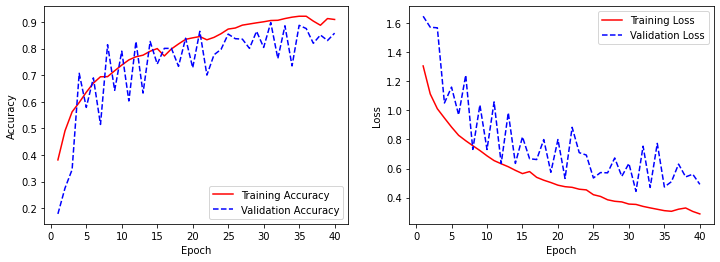

In [ ]:
# Plot results for ANN

dict_hist_ann2 = history_model_ann2.history
iepoch = np.arange(1,41)
plot_acc(dict_hist_ann2, iepoch)

## CNN models ##

In [57]:
# Build a CNN
# Conv2D and LeakyReLU layers, followed by MaxPool2D, Flatten, 
# fully connected Dense layer with LeakyReLU,
# and final Dense layer with softmax activation
# A kernel size of 3 is used
# A slope of 0.1 for LeakyReLU is used.

# Function with default parameters
def convNN(in_shape=in_shape, layers=[8,16], ndense=16, num_classes=num_classes, 
           lr=0.001):
  i = Input(shape=in_shape)
  kernel_size = 3
  leakyrelu_slope = 0.1

  for nlayer, nfilters in enumerate(layers):
    if (nlayer==0):
      x = Conv2D(nfilters, kernel_size=kernel_size, padding='same')(i)
    else:
      x = Conv2D(nfilters, kernel_size=kernel_size, padding='same')(x)
    x = LeakyReLU(leakyrelu_slope)(x)

  x = MaxPool2D(pool_size=2)(x)
  x = Flatten()(x)
  x = Dense(ndense)(x)
  x = LeakyReLU(leakyrelu_slope)(x)
  x = Dense(num_classes, activation='softmax')(x)

  model_cnn = Model(inputs=i, outputs=x)
  adam = optimizers.Adam(lr=lr)
  model_cnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  return model_cnn

In [ ]:
# CNN with 16 and 32 filters in Conv2D layers, and 32 units in fully connected dense layer
lr = 0.001

model_cnn1 = convNN(in_shape, [16,32], 32, num_classes, lr)

In [ ]:
model_cnn1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 180000)            0   

In [ ]:
# CNN is fit with image augmentation. It does not perform well with image augmentation.

history_model_cnn1 = model_cnn1.fit(train_gen, validation_data=val_gen,
                                    steps_per_epoch=STEP_SIZE_TRAIN,
                                    validation_steps=STEP_SIZE_VAL,
                                    epochs=40)

Epoch 1/40
18/18 [==============================] - 6s 338ms/step - loss: 432.5375 - accuracy: 0.3779 - val_loss: 10.3663 - val_accuracy: 0.5215
Epoch 2/40
18/18 [==============================] - 6s 316ms/step - loss: 20.7084 - accuracy: 0.5423 - val_loss: 3.0708 - val_accuracy: 0.7441
Epoch 3/40
18/18 [==============================] - 6s 315ms/step - loss: 3.7671 - accuracy: 0.6379 - val_loss: 3.5568 - val_accuracy: 0.3457
Epoch 4/40
18/18 [==============================] - 6s 317ms/step - loss: 2.2899 - accuracy: 0.6862 - val_loss: 2.3712 - val_accuracy: 0.5703
Epoch 5/40
18/18 [==============================] - 6s 316ms/step - loss: 1.9471 - accuracy: 0.6839 - val_loss: 1.7959 - val_accuracy: 0.5820
Epoch 6/40
18/18 [==============================] - 6s 315ms/step - loss: 1.3129 - accuracy: 0.7261 - val_loss: 3.9272 - val_accuracy: 0.2676
Epoch 7/40
18/18 [==============================] - 6s 321ms/step - loss: 1.0410 - accuracy: 0.7557 - val_loss: 0.0690 - val_accuracy: 0.9766
Ep

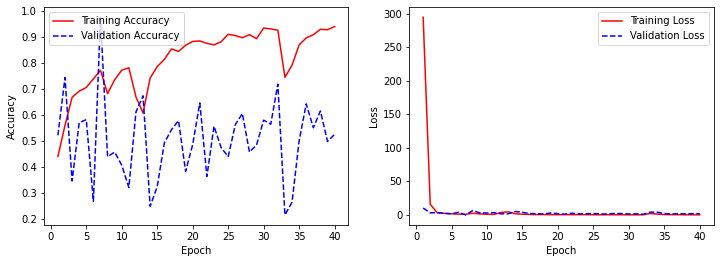

In [ ]:
# Plot results
# The CNN model with image augmentation does not perform well

dict_hist_cnn1 = history_model_cnn1.history
iepoch = np.arange(1, 41)
plot_acc(dict_hist_cnn1, iepoch)

Since image augmentation does not give good results, it will not be used here.

In [ ]:
# CNN model without image generator
# CNN with 16 and 32 filters in Conv2D layers, and 32 units in fully connected dense layer
lr = 0.001

model_cnn2 = convNN(in_shape, [16,32], 32, num_classes, lr)

In [ ]:
history_model_cnn2= model_cnn2.fit(X_train, y_train_e, validation_split=0.2, 
                                   verbose=1, batch_size=256, epochs=40)

Epoch 1/40
9/9 [==============================] - 1s 86ms/step - loss: 1.6286 - accuracy: 0.3137 - val_loss: 1.2942 - val_accuracy: 0.4298
Epoch 2/40
9/9 [==============================] - 1s 64ms/step - loss: 0.9493 - accuracy: 0.5640 - val_loss: 0.6913 - val_accuracy: 0.8094
Epoch 3/40
9/9 [==============================] - 1s 63ms/step - loss: 0.6345 - accuracy: 0.7383 - val_loss: 0.5212 - val_accuracy: 0.8596
Epoch 4/40
9/9 [==============================] - 1s 63ms/step - loss: 0.4233 - accuracy: 0.8555 - val_loss: 0.4238 - val_accuracy: 0.8960
Epoch 5/40
9/9 [==============================] - 1s 64ms/step - loss: 0.2980 - accuracy: 0.9040 - val_loss: 0.3222 - val_accuracy: 0.9203
Epoch 6/40
9/9 [==============================] - 1s 105ms/step - loss: 0.1852 - accuracy: 0.9574 - val_loss: 0.5735 - val_accuracy: 0.8215
Epoch 7/40
9/9 [==============================] - 1s 63ms/step - loss: 0.1115 - accuracy: 0.9828 - val_loss: 0.7329 - val_accuracy: 0.7903
Epoch 8/40
9/9 [==========

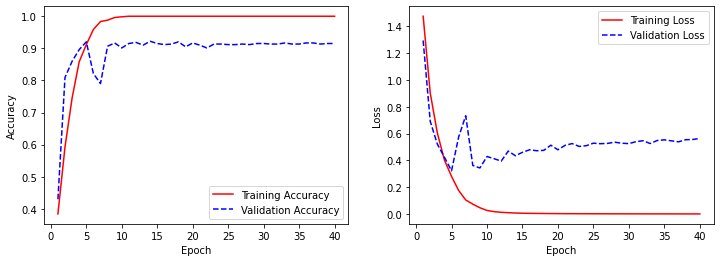

In [ ]:
# Plotting the accuracy and loss

dict_hist_cnn2 = history_model_cnn2.history
iepoch = [i for i in range(1,41)]

plot_acc(dict_hist_cnn2, iepoch)


The above CNN model performs better without image augmentation, but is overfitting. A CNN model with fewer filters is tried below.

In [58]:
# CNN model with fewer filters
# CNN with 8 and 16 filters in Conv2D layers, and 16 units in fully connected dense layer
lr = 0.001

model_cnn3 = convNN(in_shape, [8,16], 16, num_classes, lr)

model_cnn3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 8)       80        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 150, 150, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      1168      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 90000)             0   

In [ ]:
history_model_cnn3 = model_cnn3.fit(X_train, y_train_e, validation_split=0.2, 
                                   verbose=1, batch_size=512, epochs=40)

Epoch 1/40
5/5 [==============================] - 1s 118ms/step - loss: 1.3689 - accuracy: 0.3255 - val_loss: 1.6488 - val_accuracy: 0.0000e+00
Epoch 2/40
5/5 [==============================] - 0s 75ms/step - loss: 1.1298 - accuracy: 0.4471 - val_loss: 1.5940 - val_accuracy: 0.0953
Epoch 3/40
5/5 [==============================] - 0s 74ms/step - loss: 0.9589 - accuracy: 0.5382 - val_loss: 1.1821 - val_accuracy: 0.5737
Epoch 4/40
5/5 [==============================] - 0s 74ms/step - loss: 0.8509 - accuracy: 0.6305 - val_loss: 1.3259 - val_accuracy: 0.4073
Epoch 5/40
5/5 [==============================] - 0s 75ms/step - loss: 0.7549 - accuracy: 0.6639 - val_loss: 1.1697 - val_accuracy: 0.5095
Epoch 6/40
5/5 [==============================] - 0s 74ms/step - loss: 0.6715 - accuracy: 0.7020 - val_loss: 0.9160 - val_accuracy: 0.7019
Epoch 7/40
5/5 [==============================] - 0s 74ms/step - loss: 0.5977 - accuracy: 0.7522 - val_loss: 0.8772 - val_accuracy: 0.7262
Epoch 8/40
5/5 [======

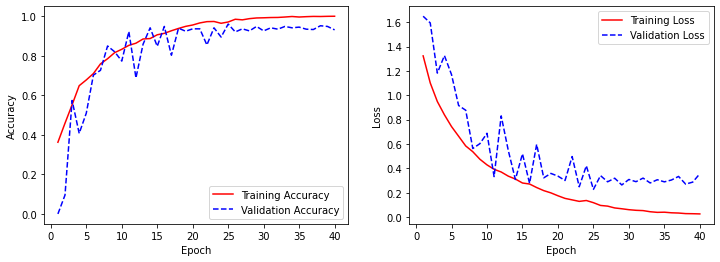

In [ ]:
# Plot results

dict_hist_cnn3 = history_model_cnn3.history
iepoch = np.arange(1,41)
plot_acc(dict_hist_cnn3, iepoch)

Dropout layers are added below to reduce overfitting and make the model generalize better. 

## CNN with Dropout ##

In [59]:
# Build a CNN with Dropout layers to prevent overfitting
# Conv2D, LeakyReLU and Dropout layers, 
# Followed by MaxPool2D, Flatten, and fully connected Dense layers with LeakyReLU and Dropout
# and final output Dense layer
# Using pool_size of 2

def ConvNNdo(in_shape, layers, kernelsize, ndense, num_classes, lr):

  leakyrelu_slope = 0.1
  # Dropout fraction for conv layers
  dropout1 = 0.2
  # Dropout fraction for dense layer
  # Dropout fraction of 0.2 was also tried, but increased to 0.5 to reduce overfitting
  dropout2 = 0.5

  i = Input(shape=in_shape)

  for nlayer, nfilters in enumerate(layers):
    if (nlayer==0):
      x = Conv2D(nfilters, kernel_size=kernelsize, padding='same')(i)
    else:
      x = Conv2D(nfilters, kernel_size=kernelsize, padding='same')(x)
    x = LeakyReLU(leakyrelu_slope)(x)
    x = Dropout(dropout1)(x)

  x = MaxPool2D(pool_size=2)(x)
  x = Flatten()(x)
  x = Dense(ndense)(x)
  x = LeakyReLU(leakyrelu_slope)(x)
  x = Dropout(dropout2)(x)
  x = Dense(num_classes, activation='softmax')(x)

  model_cnndo = Model(inputs=i, outputs=x)

  adam = optimizers.Adam(lr=lr)
  model_cnndo.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  return model_cnndo



In [60]:
# Conv layers with [8,16,32,16,8] filters
# Dense layer with 32 units

kernelsize = 3
model_cnndo1 = ConvNNdo(in_shape, [8,16,32,16,8], kernelsize, 32, num_classes, lr)
model_cnndo1.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 8)       80        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 150, 150, 8)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 150, 150, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 16)      1168      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 150, 150, 16)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 150, 150, 16)      0   

In [ ]:
history_model_cnndo1 = model_cnndo1.fit(X_train, y_train_e, 
                                        validation_split=0.2,
                                        verbose=1, batch_size=128, 
                                        shuffle=True, epochs=40)

Epoch 1/40
18/18 [==============================] - 8s 113ms/step - loss: 1.4391 - accuracy: 0.3705 - val_loss: 1.5592 - val_accuracy: 0.0000e+00
Epoch 2/40
18/18 [==============================] - 1s 83ms/step - loss: 1.1740 - accuracy: 0.4622 - val_loss: 1.1723 - val_accuracy: 0.5633
Epoch 3/40
18/18 [==============================] - 1s 82ms/step - loss: 1.0315 - accuracy: 0.5230 - val_loss: 0.5481 - val_accuracy: 0.8804
Epoch 4/40
18/18 [==============================] - 1s 83ms/step - loss: 0.8794 - accuracy: 0.6121 - val_loss: 0.5019 - val_accuracy: 0.8059
Epoch 5/40
18/18 [==============================] - 1s 82ms/step - loss: 0.7147 - accuracy: 0.7083 - val_loss: 0.6757 - val_accuracy: 0.7192
Epoch 6/40
18/18 [==============================] - 1s 83ms/step - loss: 0.6592 - accuracy: 0.7297 - val_loss: 0.4047 - val_accuracy: 0.8510
Epoch 7/40
18/18 [==============================] - 1s 82ms/step - loss: 0.5103 - accuracy: 0.7738 - val_loss: 0.6017 - val_accuracy: 0.7591
Epoch 8/

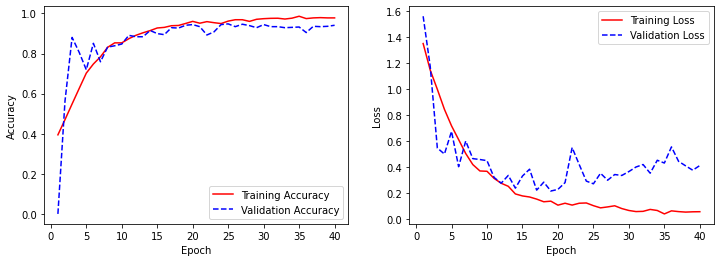

In [ ]:
# Results 

dict_hist_cnndo1 = history_model_cnndo1.history
iepoch = np.arange(1,41)
plot_acc(dict_hist_cnndo1, iepoch)

* This model did not improve performance.
* The loss plot shows that there is overfitting after about epoch 20.

Other hyperparameters were tried, as shown below:
* Kernel size of 3 or 5 was tried.
* 2 to 5 Conv layers with filters of 8, 16, 32.
* Dense layer with units of 8, 16, 32, or 256.


## LeNet-5-type architecture ##

Below, the LeNet-5-type architecture is tried. This is set up with two convolutional layers with leaky relu, each followed by max pooling, and two fully connected dense layers with leaky relu activation. Dropout or batch normalization are added to reduce overfitting.

In [61]:
# LeNet-5-type architecture
# Conv2D, MaxPool2D 2X2 layers
# Dense layers
# Output layer
# Optional Dropout or Batch Normalization after Conv and Dense layers

class conv_Layers:

  def __init__(self, nfilters, kernel_size, stride=1, 
               pool_size=2, leakyrelu_slope=0.1, dropc=0.0, bnorm=False):
    self.nfilters = nfilters
    self.kernel_size = kernel_size
    self.stride = stride
    self.pool_size = pool_size
    self.leakyrelu_slope = leakyrelu_slope
    self.dropfrac = dropc
    self.bnorm = bnorm
  
  def __call__(self, x):
    x = Conv2D(self.nfilters, kernel_size=self.kernel_size, 
               strides=self.stride, padding='same')(x)
    x = LeakyReLU(self.leakyrelu_slope)(x)
    if (self.dropfrac > 0.0): 
      x = Dropout(self.dropfrac)(x)
    if (self.bnorm):
      x = BatchNormalization()(x)
    x = MaxPool2D(self.pool_size)(x)
    return x

class dense_Layers:

  def __init__(self, nunits, leakyrelu_slope=0.1, dropd=0.0, bnorm=False):
    self.nunits = nunits
    self.leakyrelu_slope = leakyrelu_slope 
    self.dropfrac = dropd
    self.bnorm = bnorm

  def __call__(self, x):
    x = Dense(self.nunits)(x)
    x = LeakyReLU(self.leakyrelu_slope)(x)
    if (self.dropfrac > 0.0):
      x = Dropout(self.dropfrac)(x)
    if (self.bnorm):
      x = BatchNormalization()(x)
    return x

def LNmodel(in_shape, conv_filters, dense_filters, kernel_size, num_classes, lr,
            stride=1, pool_size=2, leakyrelu_slope=0.1, dropc=0.0, dropd=0.0, bnorm=False):

  i = Input(shape=in_shape)
  for ncl, nconvfilters in enumerate(conv_filters):
    if (ncl==0):
      x = conv_Layers(nconvfilters, kernel_size,
                      stride, pool_size, leakyrelu_slope, dropc, bnorm)(i)
    else:
      x = conv_Layers(nconvfilters, kernel_size,
                      stride, pool_size, leakyrelu_slope, dropc, bnorm)(x)

  x = Flatten()(x)

  for ndl, ndunits in enumerate(dense_filters):
    x = dense_Layers(ndunits, leakyrelu_slope, dropd, bnorm)(x)

  x = Dense(num_classes, activation='softmax')(x)

  ln_model  = Model(inputs=i, outputs=x)
  adam = optimizers.Adam(lr=lr)
  ln_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  return ln_model

In [62]:
# Conv2D 8 filters 5X5, MaxPool2D 2X2, Conv2D 16 filters 5X5, MaxPool2D, 2X2
# 2 Dense layers 16, 8 units
# With Dropout after conv and dense layers
# Dropout fraction of 0.25 after conv layers, 0.5 after dense layers 
# (dropout fraction of 0.2 was attempted, but higher dropout fraction performed better)

lr = 0.001
kernelsize = 5
model_ln1 = LNmodel(in_shape, [8,16], [16,8], kernelsize, num_classes, lr,
                    stride=1, pool_size=2, leakyrelu_slope=0.1, dropc=0.25, 
                    dropd=0.5, bnorm=False)
model_ln1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 150, 8)       208       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 150, 150, 8)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 150, 150, 8)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 75, 16)        3216      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 75, 75, 16)        0   

In [ ]:
history_model_ln1 = model_ln1.fit(X_train, y_train_e, 
                                  validation_split=0.2,
                                  verbose=1, batch_size=256, 
                                  shuffle=True, epochs=40)

Epoch 1/40
9/9 [==============================] - 1s 61ms/step - loss: 1.5347 - accuracy: 0.3095 - val_loss: 1.4394 - val_accuracy: 0.0000e+00
Epoch 2/40
9/9 [==============================] - 0s 39ms/step - loss: 1.3355 - accuracy: 0.3287 - val_loss: 1.5494 - val_accuracy: 0.0017
Epoch 3/40
9/9 [==============================] - 0s 38ms/step - loss: 1.2918 - accuracy: 0.4063 - val_loss: 1.5455 - val_accuracy: 0.0052
Epoch 4/40
9/9 [==============================] - 0s 38ms/step - loss: 1.2611 - accuracy: 0.4411 - val_loss: 1.5319 - val_accuracy: 0.0139
Epoch 5/40
9/9 [==============================] - 0s 39ms/step - loss: 1.2355 - accuracy: 0.4575 - val_loss: 1.4953 - val_accuracy: 0.1005
Epoch 6/40
9/9 [==============================] - 0s 40ms/step - loss: 1.1839 - accuracy: 0.4836 - val_loss: 1.4670 - val_accuracy: 0.1248
Epoch 7/40
9/9 [==============================] - 0s 39ms/step - loss: 1.1859 - accuracy: 0.4882 - val_loss: 1.4313 - val_accuracy: 0.1924
Epoch 8/40
9/9 [=======

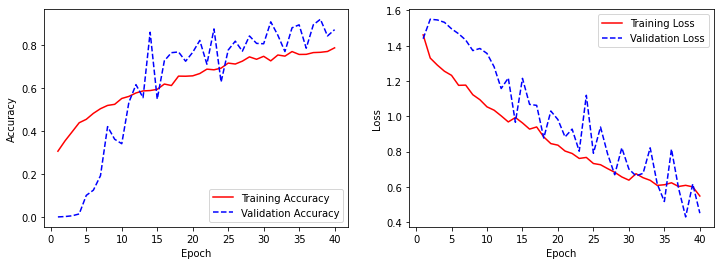

In [ ]:
# Plots

dist_hist_ln1 = history_model_ln1.history
iepoch = np.arange(1,41)

plot_acc(dist_hist_ln1, iepoch)

In [ ]:
# With Dropout and with Batch Normalization

lr = 0.001
kernelsize = 5
model_ln2 = LNmodel(in_shape, [8,16], [16,8], kernelsize, num_classes, lr,
                    stride=1, pool_size=2, leakyrelu_slope=0.1, dropc=0.25, 
                    dropd=0.5, bnorm=True)
model_ln2.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 150, 150, 8)       208       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 150, 150, 8)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 150, 150, 8)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 8)       32        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 8)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 75, 75, 16)        3216

In [ ]:
history_model_ln2 = model_ln2.fit(X_train, y_train_e, 
                                  validation_split=0.2,
                                  verbose=1, batch_size=256, 
                                  shuffle=True, epochs=40)

Epoch 1/40
9/9 [==============================] - 2s 82ms/step - loss: 1.5348 - accuracy: 0.3421 - val_loss: 1.2516 - val_accuracy: 0.7972
Epoch 2/40
9/9 [==============================] - 0s 52ms/step - loss: 1.3584 - accuracy: 0.4332 - val_loss: 0.9806 - val_accuracy: 0.9948
Epoch 3/40
9/9 [==============================] - 0s 53ms/step - loss: 1.2868 - accuracy: 0.4737 - val_loss: 0.8202 - val_accuracy: 1.0000
Epoch 4/40
9/9 [==============================] - 0s 51ms/step - loss: 1.2023 - accuracy: 0.4933 - val_loss: 0.8113 - val_accuracy: 1.0000
Epoch 5/40
9/9 [==============================] - 0s 53ms/step - loss: 1.1839 - accuracy: 0.5177 - val_loss: 0.7967 - val_accuracy: 1.0000
Epoch 6/40
9/9 [==============================] - 0s 53ms/step - loss: 1.0829 - accuracy: 0.5714 - val_loss: 0.8510 - val_accuracy: 1.0000
Epoch 7/40
9/9 [==============================] - 0s 52ms/step - loss: 1.0903 - accuracy: 0.5506 - val_loss: 0.8743 - val_accuracy: 1.0000
Epoch 8/40
9/9 [===========

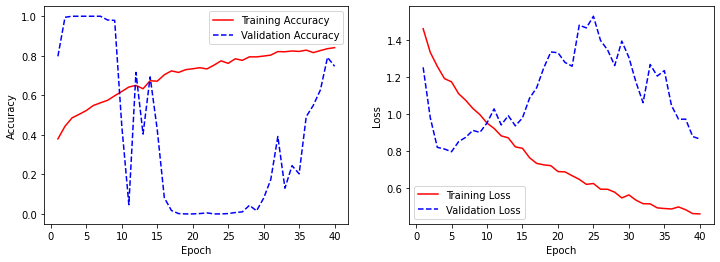

In [ ]:
# Plots

dict_hist_ln2 = history_model_ln2.history
iepoch = np.arange(1,41)
plot_acc(dict_hist_ln2, iepoch)

Batch normalization does not perform well. Below, only Dropout is used.

A validation split of 0.1 is used below to provide more training data. 

In [63]:
# Conv2D 8 filters 5X5, MaxPool2D 2X2, Conv2D 16 filters 5X5, MaxPool2D, 2X2
# 2 Dense layers 512, 256 units
# Dropout 0.25 after conv layers, 0.5 after dense layers
# validation split = 0.1

lr = 0.001
kernelsize = 5
model_ln3 = LNmodel(in_shape, [8,16], [512,256], kernelsize, num_classes, lr,
                    stride=1, pool_size=2, leakyrelu_slope=0.1, dropc=0.25,
                    dropd=0.5, bnorm=False)
model_ln3.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 150, 150, 8)       208       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 150, 150, 8)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 150, 150, 8)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 16)        3216      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 75, 75, 16)        0   

In [64]:
from keras.callbacks import EarlyStopping

In [ ]:
# Early stopping (commented out as it did not improve performance)
Estopp = EarlyStopping(monitor='val_loss', patience=5)

history_model_ln3 = model_ln3.fit(X_train, y_train_e, 
                                  validation_split=0.1,
                                  verbose=1, batch_size=512, 
                               #   callbacks=[Estopp],
                                  shuffle=True, epochs=40)

Epoch 1/40
6/6 [==============================] - 1s 91ms/step - loss: 2.5152 - accuracy: 0.3171 - val_loss: 1.3387 - val_accuracy: 0.1765
Epoch 2/40
6/6 [==============================] - 0s 59ms/step - loss: 1.2941 - accuracy: 0.3814 - val_loss: 1.1457 - val_accuracy: 0.8478
Epoch 3/40
6/6 [==============================] - 0s 59ms/step - loss: 1.1141 - accuracy: 0.4996 - val_loss: 0.9243 - val_accuracy: 0.7924
Epoch 4/40
6/6 [==============================] - 0s 59ms/step - loss: 0.9639 - accuracy: 0.5697 - val_loss: 0.6222 - val_accuracy: 0.8166
Epoch 5/40
6/6 [==============================] - 0s 58ms/step - loss: 0.8473 - accuracy: 0.6254 - val_loss: 0.3291 - val_accuracy: 0.9343
Epoch 6/40
6/6 [==============================] - 0s 59ms/step - loss: 0.7679 - accuracy: 0.6751 - val_loss: 0.4912 - val_accuracy: 0.8997
Epoch 7/40
6/6 [==============================] - 0s 56ms/step - loss: 0.6780 - accuracy: 0.7095 - val_loss: 0.3017 - val_accuracy: 0.9446
Epoch 8/40
6/6 [===========

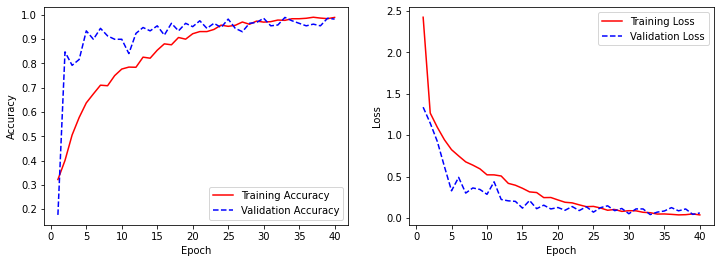

In [ ]:
# Plots

dict_hist_ln3 = history_model_ln3.history
iepoch = np.arange(1,41)
plot_acc(dict_hist_ln3, iepoch)

Other models and hyperparameters were tried, with or without an additional dropout layer between the convolutional and dense layers, with the convolutional layers having filters of 8, 16, 32, 64 or up to 128, and 2 or 3 dense layers having units of 1024, 512, 256, 128, or 32. Different leaky relu slopes (0.2 or 0) were tried but 0.1 performed better. Kernel size of 3 or 5 was tried. The validation split was set to 0.1 or 0.2. 

Findings:
* Filters of 8, 16 are sufficient in Conv layer
* Number of units in dense layer can be increased (for example, up to 1024, 512, 256)
* Using 8 and 16 units in dense layers did not perform well
* Leaky relu slope of 0.1 performs well
* Dropout of 0.25 for conv layers and 0.5 for dense layers performs well
* Validation split of 0.1 gives more training data and can improve accuracy

## ***Making predictions on the test images with the models providing good validation accuracy:*** ##

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# Test prediction with model cnn3 
# CNN with 8 and 16 filters in Conv2D layers, and 16 units in fully connected dense layer
# kernel size of 3
# No Dropout layers

y_test_pred_cnn3 = model_cnn3.predict(X_test)
y_test_pred_classes_cnn3 = np.argmax(y_test_pred_cnn3, axis=1)

In [ ]:
accuracy_score(y_test, y_test_pred_classes_cnn3)

0.7412935323383084

[Text(0, 0.5, 'Glioma'),
 Text(0, 1.5, 'Meningioma'),
 Text(0, 2.5, 'None'),
 Text(0, 3.5, 'Pituitary')]

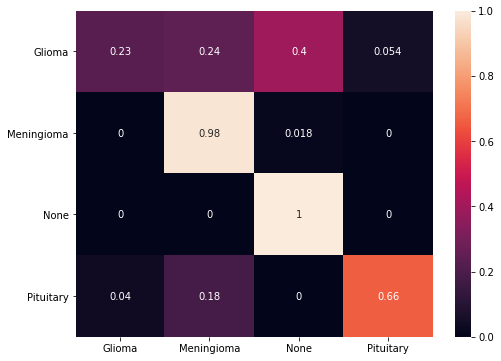

In [ ]:
cf_matrix = confusion_matrix(y_test, y_test_pred_classes_cnn3)

# Confusion matrix normalized per category true value
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cf_matrix_n1, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)
ax.set_xticklabels(Cat_names)
ax.set_yticklabels(Cat_names)

In [ ]:
# Test prediction with model_cnndo1, 
# Conv2D 8,16,32,16,8 filters, dense layer with 32 units
# with Dropout layers

y_test_predcdo1 = model_cnndo1.predict(X_test)
y_test_pred_classescdo1 = np.argmax(y_test_predcdo1, axis=1)
y_test_pred_probcdo1 = np.max(y_test_predcdo1, axis=1)

In [ ]:
accuracy_score(y_test, y_test_pred_classescdo1)

0.6766169154228856

[Text(0, 0.5, 'Glioma'),
 Text(0, 1.5, 'Meningioma'),
 Text(0, 2.5, 'None'),
 Text(0, 3.5, 'Pituitary')]

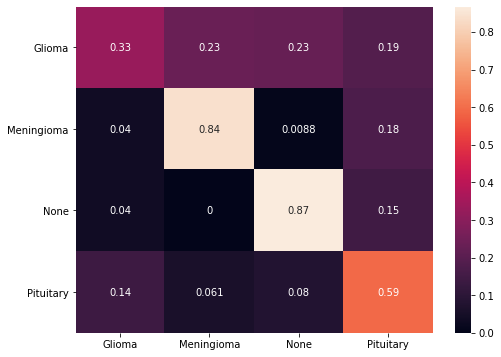

In [ ]:
cf_matrix = confusion_matrix(y_test, y_test_pred_classescdo1)

# Confusion matrix normalized per category true value
cf_matrix = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cf_matrix, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)
ax.set_xticklabels(Cat_names)
ax.set_yticklabels(Cat_names)

In [ ]:
# Test prediction with model_ln3, 
# Conv2D 8 filters 5X5, MaxPool2D 2X2, Conv2D 16 filters 5X5, MaxPool2D, 2X2
# 2 Dense layers 512, 256 units
# with Dropout layers

y_test_pred_ln3 = model_ln3.predict(X_test)
y_test_pred_classes_ln3 = np.argmax(y_test_pred_ln3, axis=1)
y_test_pred_prob_ln3 = np.max(y_test_pred_ln3, axis=1)


In [ ]:
accuracy_score(y_test, y_test_pred_classes_ln3)


0.7711442786069652

[Text(0, 0.5, 'Glioma'),
 Text(0, 1.5, 'Meningioma'),
 Text(0, 2.5, 'None'),
 Text(0, 3.5, 'Pituitary')]

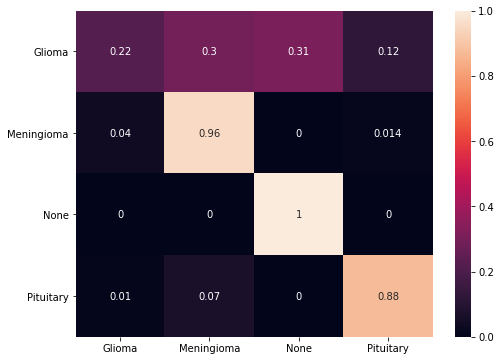

In [ ]:
cf_matrix = confusion_matrix(y_test, y_test_pred_classes_ln3)

# Confusion matrix normalized per category true value
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cf_matrix_n1, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)
ax.set_xticklabels(Cat_names)
ax.set_yticklabels(Cat_names)

### Conclusions: ###
* The models developed here provide a maximum accuracy of about 0.77 on the test set.
* The meningioma tumors and no tumors can be predicted well, but pituitary and especially glioma tumors are not predicted well.
* The prediction of pituitary tumors could be improved with LeNet-5-type architecture, but the glioma tumors are not predicted well.

## Grid Search Hyperparameters ##

Try Grid Search using the CNN model.

Using the more complicated architectures with dropout layers or LeNet-5 did not provide a large improvement. So the CNN model is tried here.

In [28]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# Model definition
def create_model(learn_rate=0.001):
  kernel_size = 3
  leakyrelu_slope = 0.1
  model = Sequential()
  model.add(Conv2D(filters=8, kernel_size=kernel_size, padding='same', input_shape=in_shape))
  model.add(LeakyReLU(leakyrelu_slope))
  model.add(Conv2D(filters=16, kernel_size=kernel_size, padding='same'))
  model.add(LeakyReLU(leakyrelu_slope))
  model.add(MaxPool2D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(16))
  model.add(LeakyReLU(leakyrelu_slope))
  model.add(Dense(num_classes, activation='softmax'))
  adam = optimizers.Adam(lr=learn_rate)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model

# Grid search for learning rate and batch size
smodel = KerasClassifier(build_fn=create_model, verbose=0, epochs=20)
param_grid = {'learn_rate': [0.001, 0.005, 0.01], 'batch_size': [64, 128, 256, 512]}
grid = GridSearchCV(estimator=smodel, param_grid=param_grid, n_jobs=1, cv=5, 
                    return_train_score=True)

grid_result = grid.fit(X_train, y_train_e)

grid_result.cv_results_

# Notes: did not work for epochs
# predict_classes method is only available for the Sequential class 
# but not for the Model class

{'mean_fit_time': array([6.73257427, 7.02899361, 6.72137218, 6.33452239, 6.3184577 ,
        6.34257779, 6.26131725, 6.1129858 , 6.10573015, 6.1339931 ,
        6.00607953, 6.00552015]),
 'mean_score_time': array([0.20546956, 0.20721302, 0.3397665 , 0.21378832, 0.22186027,
        0.21873727, 0.21203566, 0.21119227, 0.20991254, 0.20791683,
        0.20605931, 0.20842381]),
 'mean_test_score': array([0.71678342, 0.67791859, 0.66436729, 0.69974244, 0.63658048,
        0.59879404, 0.58554844, 0.6216698 , 0.66434565, 0.61478793,
        0.63112904, 0.55270014]),
 'mean_train_score': array([1.        , 1.        , 1.        , 0.99592191, 0.97492408,
        0.91391958, 0.93856728, 0.9645987 , 0.87557472, 0.95748063,
        0.97430793, 0.8988094 ]),
 'param_batch_size': masked_array(data=[64, 64, 64, 128, 128, 128, 256, 256, 256, 512, 512,
                    512],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
  

In [ ]:
print("Best score: {}, parameters: {}".format(grid_result.best_score_, 
                                          grid_result.best_params_))
mean = grid_result.cv_results_['mean_test_score']
std = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print(mean, std, params)

Best score: 0.7167834162712097, parameters: {'batch_size': 64, 'learn_rate': 0.001}
[0.71678342 0.67791859 0.66436729 0.69974244 0.63658048 0.59879404
 0.58554844 0.6216698  0.66434565 0.61478793 0.63112904 0.55270014] [0.12797901 0.13467138 0.12607258 0.14214593 0.1503793  0.17961546
 0.16470551 0.20812405 0.09190727 0.19774788 0.1966832  0.21130394] [{'batch_size': 64, 'learn_rate': 0.001}, {'batch_size': 64, 'learn_rate': 0.005}, {'batch_size': 64, 'learn_rate': 0.01}, {'batch_size': 128, 'learn_rate': 0.001}, {'batch_size': 128, 'learn_rate': 0.005}, {'batch_size': 128, 'learn_rate': 0.01}, {'batch_size': 256, 'learn_rate': 0.001}, {'batch_size': 256, 'learn_rate': 0.005}, {'batch_size': 256, 'learn_rate': 0.01}, {'batch_size': 512, 'learn_rate': 0.001}, {'batch_size': 512, 'learn_rate': 0.005}, {'batch_size': 512, 'learn_rate': 0.01}]


### Conclusions ###
Grid Search with 5-fold cross-validation gave various solutions, such as batch size 64, lr 0.001; batch size 256, lr 0.005; and batch size 512, lr 0.005. Learning rate of 0.001 or 0.005 works better, but batch size does not have much effect.

## Keras Tuner ##

Try keras tuner for tuning the models.

In [29]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 7.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=189aadca4144d9547a8320bbdebe7540b15bdce91cbf38b3d8c50b1228953b6f
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=ba7f13003ae3a7095c782474f1a2b11e77fff9de3534fb2b541fb60d10c7c5d9
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [30]:
from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner import HyperModel

In [123]:
# Define model: CNN model with dropout layer

class CNNhypermodel(HyperModel):
  def __init__(self, in_shape, num_classes):
    self.in_shape = in_shape
    self.num_classes = num_classes

  def build(self, hp):
    inputs = Input(shape=self.in_shape)
    for idx, i in enumerate(range(hp.Int('num_layers', 2, 8, step=2))):
      x = inputs if idx==0 else x
      x = Conv2D(filters=hp.Int('filter'+str(i), min_value=8, max_value=256, step=16),
                 kernel_size=hp.Int('kernel_size'+str(i), min_value=3, max_value=6, step=1),
                 padding='same')(x)
      x = LeakyReLU(0.1)(x)
    x = MaxPool2D(pool_size=hp.Int('pool_size', min_value=2, max_value=4, step=1))(x)
    x = Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.6, step=0.2))(x)
    x = Flatten()(x)
    x = Dense(hp.Int('dense_units', min_value=16, max_value=256, step=16))(x)
    x = LeakyReLU(0.1)(x)
    x = Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.6, step=0.2))(x)
    x = Dense(self.num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)

    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])
    return model
    


In [124]:
chmodel = CNNhypermodel(in_shape=in_shape, num_classes=num_classes)

# Using RandomSearch
tuner1 = RandomSearch(chmodel,
                      objective='val_accuracy',
                      max_trials=5,
                      directory='.',
                      project_name='capstone'
                     )

tuner1.search(X_train, y_train_e, epochs=20, validation_split=0.2, shuffle=True)

tuner1.results_summary()

INFO:tensorflow:Reloading Oracle from existing project ./capstone/oracle.json
INFO:tensorflow:Reloading Tuner from ./capstone/tuner0.json
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./capstone
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 8
filter0: 120
kernel_size0: 3
filter1: 24
kernel_size1: 3
pool_size: 2
dropout_1: 0.4
dense_units: 256
dropout_2: 0.2
filter2: 104
kernel_size2: 6
filter3: 248
kernel_size3: 5
filter4: 152
kernel_size4: 3
filter5: 152
kernel_size5: 5
filter6: 8
kernel_size6: 3
filter7: 8
kernel_size7: 3
Score: 0.9792027473449707
Trial summary
Hyperparameters:
num_layers: 4
filter0: 168
kernel_size0: 3
filter1: 136
kernel_size1: 6
pool_size: 2
dropout_1: 0.4
dense_units: 176
dropout_2: 0.0
filter2: 8
kernel_size2: 3
filter3: 8
kernel_size3: 3
Score: 0.9653379321098328
Trial summary
Hyperparameters:
num_layers: 6
filter0: 200
kernel_size0: 5
filter1: 88
kernel_size1: 4
pool_size: 3

In [125]:
model1 = tuner1.get_best_models(num_models=1)[0]

history_mod1 = model1.fit(X_train, y_train_e, validation_split=0.2, shuffle=True, epochs=20, verbose=1, batch_size=32)


Epoch 1/20
72/72 [==============================] - 20s 271ms/step - loss: 90.7017 - accuracy: 0.3688 - val_loss: 28.5718 - val_accuracy: 0.1768
Epoch 2/20
72/72 [==============================] - 19s 268ms/step - loss: 8.6355 - accuracy: 0.4121 - val_loss: 2.7347 - val_accuracy: 0.6360
Epoch 3/20
72/72 [==============================] - 19s 268ms/step - loss: 4.1646 - accuracy: 0.4262 - val_loss: 2.0951 - val_accuracy: 0.4523
Epoch 4/20
72/72 [==============================] - 19s 269ms/step - loss: 3.0751 - accuracy: 0.4166 - val_loss: 2.4279 - val_accuracy: 0.3934
Epoch 5/20
72/72 [==============================] - 19s 269ms/step - loss: 2.1593 - accuracy: 0.4297 - val_loss: 2.0089 - val_accuracy: 0.3553
Epoch 6/20
72/72 [==============================] - 19s 268ms/step - loss: 1.3865 - accuracy: 0.4638 - val_loss: 2.0830 - val_accuracy: 0.1577
Epoch 7/20
72/72 [==============================] - 19s 268ms/step - loss: 64.5876 - accuracy: 0.3801 - val_loss: 24.3422 - val_accuracy: 0.

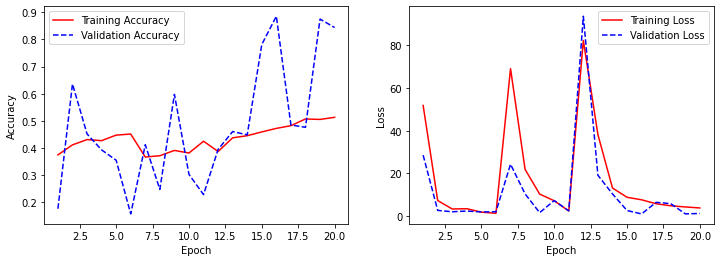

In [126]:
iepoch = np.arange(1,21)
plot_acc(history_mod1.history, iepoch)


In [131]:
test_acc_model1 = model1.evaluate(X_test, y_test_e)

13/13 [==============================] - 1s 77ms/step - loss: 8.3130 - accuracy: 0.4129


In [132]:
y_test_pred_hmod1 = model1.predict(X_test)
y_test_pred_hmod1_cl = np.argmax(y_test_pred_hmod1, axis=1)

In [133]:
accuracy_score(y_test, y_test_pred_hmod1_cl) 

0.4129353233830846

[Text(0, 0.5, 'Glioma'),
 Text(0, 1.5, 'Meningioma'),
 Text(0, 2.5, 'None'),
 Text(0, 3.5, 'Pituitary')]

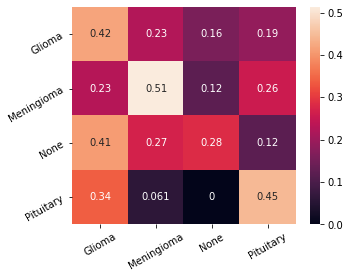

In [134]:
cm_hmod1 = confusion_matrix(y_test, y_test_pred_hmod1_cl)
cm_hmod1 = cm_hmod1/np.sum(cm_hmod1, axis=1)
plt.figure(figsize=(5,4))
ax = sns.heatmap(cm_hmod1, annot=True)
ax.set_xticklabels(Cat_names, rotation=30)
ax.set_yticklabels(Cat_names, rotation=30)

In [ ]:
# model1.save('ranhypermodel1.h5') # saving model, accuracy of 0.70 on the test set
# best case model found on running random search several times had accuracy of 0.73 on the test set

In [ ]:
#model1.summary() # model summary

In [33]:
# LeNet-5-type model with Bayesian Optimization

class LNhypermodel(HyperModel):
  def __init__(self, in_shape, num_classes):
    self.in_shape = in_shape
    self.num_classes = num_classes

  def build(self, hp):
    inputs = Input(shape=self.in_shape)
    for idx, i in enumerate(range(hp.Int('conv_layers', min_value=2, max_value=6, step=2))):
      if idx==0:
        x = inputs
      x = Conv2D(filters=hp.Int('filters'+str(i), min_value=8, max_value=128, step=32),
                 kernel_size=hp.Int('kernel_size', min_value=3, max_value=5, step=1),
                 padding='same')(x)
      x = LeakyReLU(0.1)(x)
      x = Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.4, step=0.2))(x)
      #x = MaxPool2D(pool_size=hp.Int('pool_size'+str(i), min_value=2, max_value=4, step=1), data_format='channels_last')(x)
      x = MaxPool2D(pool_size=2)(x)  # fix pool size
    x = Flatten()(x)
    for j in range(hp.Int('dense_layers', min_value=2, max_value=8, step=2)):
      x = Dense(hp.Int('units'+str(j), min_value=8, max_value=512, step=32))(x)
      x = LeakyReLU(0.1)(x)
      x = Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.6, step=0.2))(x)
    x = Dense(self.num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.Adam(lr=0.005), 
                  metrics=['accuracy'])
    return model

lnhmodel = LNhypermodel(in_shape=in_shape, num_classes=num_classes)
tuner_ln = BayesianOptimization(lnhmodel,
                                objective='val_accuracy',
                                max_trials=10,
                                executions_per_trial=5,
                                directory='.',
                                project_name='capstone_lenet')

tuner_ln.search(X_train, y_train_e, validation_split=0.2, shuffle=True, verbose=1, epochs=20)

In [34]:
best_model_ln = tuner_ln.get_best_models(num_models=1)[0]
best_model_ln.evaluate(X_test, y_test_e)

13/13 [==============================] - 0s 6ms/step - loss: 90.7153 - accuracy: 0.0685


[83.23939514160156, 0.19402985274791718]

In [35]:
# ResNet model with keras tuner and Hyperband optimization

from kerastuner.applications import HyperResNet
from kerastuner.tuners import Hyperband

hypermodel = HyperResNet(input_shape=in_shape, classes=num_classes)
tuner_rn = Hyperband(hypermodel,
                     objective='val_accuracy',
                     max_epochs=20,
                     hyperband_iterations=1,
                     directory='.',
                     project_name='capstone_resnet'
                    )
         
tuner_rn.search(X_train, y_train_e, validation_split=0.2)


Trial 30 Complete [00h 03m 12s]
val_accuracy: 0.45753899216651917

Best val_accuracy So Far: 0.9757365584373474
Total elapsed time: 00h 52m 06s
INFO:tensorflow:Oracle triggered exit


In [36]:
model_rn = tuner_rn.get_best_models(num_models=1)[0]
test_acc_model_rn = model_rn.evaluate(X_test, y_test_e)

13/13 [==============================] - 7s 47ms/step - loss: 7.5115 - accuracy: 0.3121


### Conclusions: ###

Using Keras tuner did not improve accuracy for the test set, after trying different CNN architectures and ResNet, and with Random Search, Bayesian Optimization and Hyperband Optimization.

These models provide high validation accuracy, but low test accuracy.

## Autokeras ##

In [ ]:
# AutoKeras

!pip install autokeras


In [ ]:
# Autokeras

import autokeras as ak

clf = ak.ImageClassifier(max_trials=10)
clf.fit(X_train, y_train, epochs=10)

y_pred = clf.predict(X_test)

clf.evaluate(X_test, y_test)

INFO:tensorflow:Reloading Oracle from existing project ./image_classifier/oracle.json
INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
91/91 [==============================] - 16s 111ms/step - loss: 1.8827 - accuracy: 0.7697
Epoch 2/10
91/91 [==============================] - 10s 111ms/step - loss: 2.8045 - accuracy: 0.5917
Epoch 3/10
91/91 [==============================] - 10s 111ms/step - loss: 4.0358 - accuracy: 0.6357
Epoch 4/10
91/91 [==============================] - 10s 112ms/step - loss: 4.4772 - accuracy: 0.4545
Epoch 5/10
91/91 [==============================] - 10s 111ms/step - loss: 3.9600 - accuracy: 0.5307
Epoch 6/10
91/91 [==============================] - 10s 111ms/step - loss: 2.4735 - accuracy: 0.5578
Epoch 7/10
91/91 [==============================] - 10s 111ms/step - loss: 1.9147 - accuracy: 0.1778
Epoch 8/10
91/91 [==============================] - 10s 111ms/step - loss: 1.6953 - accuracy: 0.4119


[1.8763121366500854, 0.1840796023607254]

In [ ]:
# Autokeras restricting the search to ResNet architectures

inputnode = ak.ImageInput()
outputnode = ak.ImageBlock(block_type="resnet")(inputnode)
outputnode = ak.ClassificationHead()(outputnode)
clf = ak.AutoModel(inputs=inputnode, outputs=outputnode, max_trials=10)
clf.fit(X_train, y_train, epochs=10)
clf.evaluate(X_test, y_test)

INFO:tensorflow:Reloading Oracle from existing project ./auto_model/oracle.json
INFO:tensorflow:Reloading Tuner from ./auto_model/tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
91/91 [==============================] - 15s 111ms/step - loss: 3.5026 - accuracy: 0.7716
Epoch 2/10
91/91 [==============================] - 10s 110ms/step - loss: 12.3390 - accuracy: 0.6710
Epoch 3/10
91/91 [==============================] - 10s 110ms/step - loss: 4.3802 - accuracy: 0.7897
Epoch 4/10
91/91 [==============================] - 10s 110ms/step - loss: 3.0489 - accuracy: 0.8025
Epoch 5/10
91/91 [==============================] - 10s 111ms/step - loss: 3.2717 - accuracy: 0.8186
Epoch 6/10
91/91 [==============================] - 10s 110ms/step - loss: 5.1453 - accuracy: 0.7519
Epoch 7/10
91/91 [==============================] - 10s 110ms/step - loss: 4.7650 - accuracy: 0.7670
Epoch 8/10
91/91 [==============================] - 10s 110ms/step - loss: 3.3470 - accuracy: 0.8038
Epoch 9/10


[149.89791870117188, 0.1840796023607254]

### Conclusions: ###

Autokeras, and restricting the search to ResNet architectures, was attempted, but did not perform well on the test set.

## Transfer Learning ##

Transfer learning will be tried with VGG-16.

In [37]:
# Generate the images with RGB channels

# Function to create image data sets
# Reading the images from the path and labeling them into the given categories, with RGB channels

def create_data_rgb(DATADIR):
    imgset = []
    classname = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        cat_name = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                img_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                # normalize
                img_array = img_array/255.0
                # create image and category variables
                imgset.append(img_array)
                classname.append(cat_name)
            except:
                pass
    return np.array(imgset), np.array(classname)

In [38]:
# Training and test data with RGB channels
Xtrain_rgb, ytrain_rgb = create_data_rgb(TRAIN_DATADIR)
Xtest_rgb, ytest_rgb = create_data_rgb(TEST_DATADIR)

In [39]:
# Shapes
Xtrain_rgb.shape, ytrain_rgb.shape, Xtest_rgb.shape, ytest_rgb.shape

((2881, 150, 150, 3), (2881,), (402, 150, 150, 3), (402,))

In [40]:
in_shape_rgb = Xtrain_rgb.shape[1:]   # input shape

In [45]:
# Transfer Learning with VGG16
from keras.applications import vgg16

# Define function to build model
def build_vggmodel(inshape):
  vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=inshape)
  output = vgg.layers[-1].output
  output = Flatten()(output)
  vgg_model = Model(vgg.input, output)

  # Uncomment these lines if the model is not to be trainable
  #vgg_model.trainable = False
  #for layer in vgg_model.layers:
  #  layer.trainable = False

  # Trainable for conv blocks 4 and 5 here
  vgg_model.trainable = True
  for layer in vgg_model.layers:
    if layer.name in ['block4_conv1', 'block5_conv1']:
      layer.trainable = True
    else:
      layer.trainable = False

  # Deep neural network classifier with 2 dense layers of 512 units and dropout, and final dense output layer
  inshape_vgg = vgg_model.output_shape[1]

  fmodel = Sequential() 
  fmodel.add(InputLayer(input_shape=inshape_vgg))
  fmodel.add(Dense(units=512, activation='relu', input_dim=inshape_vgg))
  fmodel.add(Dropout(0.3))
  fmodel.add(Dense(units=512, activation='relu'))
  fmodel.add(Dropout(0.3))
  fmodel.add(Dense(units=num_classes, activation='softmax'))
  # Compile model
  fmodel.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])
  return vgg_model, fmodel

In [46]:
# Extract bottleneck features and feed them to classifier

from sklearn.model_selection import train_test_split

def get_bottleneck_features(model, traindata):
  features = model.predict(traindata, verbose=0)
  return features

# train test split
X1, Xv, y1, yv = train_test_split(Xtrain_rgb, ytrain_rgb, test_size=0.2, random_state=42)
# one hot encoding of target variables
y1_enc = to_categorical(y1)
yv_enc = to_categorical(yv)
# Model (VGG model and classifier)
vgg_model, fmodel = build_vggmodel(inshape=in_shape_rgb)
# Extract features
train_features_vgg = get_bottleneck_features(vgg_model, X1)
val_features_vgg = get_bottleneck_features(vgg_model, Xv)
test_features_vgg = get_bottleneck_features(vgg_model, Xtest_rgb)



In [47]:
# Fit model to extracted features
history_fmodel = fmodel.fit(train_features_vgg, y1_enc, 
                            validation_data=(val_features_vgg, yv_enc),
                            batch_size=256,
                            epochs=20,
                            verbose=1)

Epoch 1/20
9/9 [==============================] - 1s 24ms/step - loss: 2.4142 - accuracy: 0.3215 - val_loss: 0.9863 - val_accuracy: 0.5823
Epoch 2/20
9/9 [==============================] - 0s 10ms/step - loss: 1.0297 - accuracy: 0.5427 - val_loss: 0.7090 - val_accuracy: 0.7019
Epoch 3/20
9/9 [==============================] - 0s 10ms/step - loss: 0.7163 - accuracy: 0.7234 - val_loss: 0.5905 - val_accuracy: 0.7487
Epoch 4/20
9/9 [==============================] - 0s 10ms/step - loss: 0.5624 - accuracy: 0.7741 - val_loss: 0.5254 - val_accuracy: 0.7799
Epoch 5/20
9/9 [==============================] - 0s 10ms/step - loss: 0.4834 - accuracy: 0.8008 - val_loss: 0.4362 - val_accuracy: 0.8180
Epoch 6/20
9/9 [==============================] - 0s 10ms/step - loss: 0.4038 - accuracy: 0.8448 - val_loss: 0.3870 - val_accuracy: 0.8388
Epoch 7/20
9/9 [==============================] - 0s 10ms/step - loss: 0.3479 - accuracy: 0.8670 - val_loss: 0.3525 - val_accuracy: 0.8614
Epoch 8/20
9/9 [===========

In [48]:
# Test prediction
ypredvgg = fmodel.predict(test_features_vgg)
ypredvgg_classes = np.argmax(ypredvgg, axis=1)

In [49]:
# Test accuracy
accuracy_score(ytest_rgb, ypredvgg_classes)

0.7114427860696517

In [50]:
# Classification report
print(classification_report(ytest_rgb, ypredvgg_classes))

              precision    recall  f1-score   support

           0       0.95      0.20      0.33       100
           1       0.63      0.98      0.77       115
           2       0.70      0.96      0.81       113
           3       0.96      0.59      0.73        74

    accuracy                           0.71       402
   macro avg       0.81      0.69      0.66       402
weighted avg       0.79      0.71      0.67       402



[Text(0, 0.5, 'Glioma'),
 Text(0, 1.5, 'Meningioma'),
 Text(0, 2.5, 'None'),
 Text(0, 3.5, 'Pituitary')]

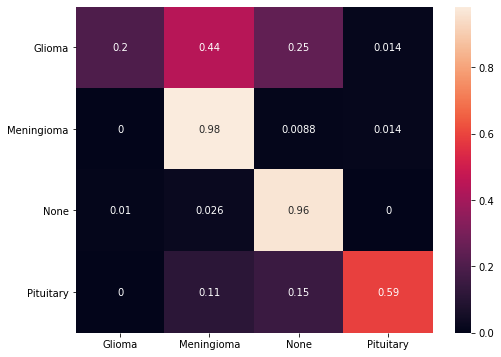

In [51]:
# Confusion matrix
cf_matrix = confusion_matrix(ytest_rgb, ypredvgg_classes)
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cf_matrix_n1, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)
ax.set_xticklabels(Cat_names)
ax.set_yticklabels(Cat_names)

### Conclusions: ###

Transfer learning with VGG-16 did not improve the accuracy of the test set prediction.

## Combining the train and test sets, and splitting the  combined dataset into train, validation and test datasets ##

In the provided training and test images, there are differences in the glioma tumors between the training and test datasets. There are different types of gliomas, and they may be differently distributed in the training and test sets. As a result, the recall score for glioma was low in the test set, even though validation accuracy was high, on using the original training and test sets. To improve the prediction and build a better model, the training and test sets are combined here, and then split into a test set, validation set and training set. This results in an improved prediction. 

In [65]:
from sklearn.model_selection import train_test_split

# Combine the train and test images provided
X_img = np.concatenate([X_train, X_test], axis=0)
y_classes = np.concatenate([y_train, y_test], axis=0)
# Split into new train and test set
Xtrn, Xtst, ytrn, ytst = train_test_split(X_img, y_classes, test_size=0.2, random_state=42, stratify=y_classes)

In [66]:
# One hot encoding of target variables
ytrn_enc = to_categorical(ytrn)
ytst_enc = to_categorical(ytst)

In [67]:
# shape of new training and test datasets
Xtrn.shape, ytrn_enc.shape

((2626, 150, 150, 1), (2626, 4))

In [68]:
Xtst.shape, ytst_enc.shape

((657, 150, 150, 1), (657, 4))

In [69]:
# Attempt the fit with previously constructed model_cnn3

history_new_modelcnn_3 = model_cnn3.fit(Xtrn, ytrn_enc, validation_split=0.2, batch_size=512, verbose=1, epochs=40)

Epoch 1/40
5/5 [==============================] - 1s 120ms/step - loss: 1.4516 - accuracy: 0.3572 - val_loss: 1.4150 - val_accuracy: 0.4354
Epoch 2/40
5/5 [==============================] - 0s 65ms/step - loss: 1.2655 - accuracy: 0.4766 - val_loss: 1.1663 - val_accuracy: 0.5019
Epoch 3/40
5/5 [==============================] - 0s 67ms/step - loss: 1.0990 - accuracy: 0.5570 - val_loss: 1.0497 - val_accuracy: 0.5304
Epoch 4/40
5/5 [==============================] - 0s 65ms/step - loss: 0.9652 - accuracy: 0.5860 - val_loss: 0.9269 - val_accuracy: 0.6369
Epoch 5/40
5/5 [==============================] - 0s 66ms/step - loss: 0.8125 - accuracy: 0.6918 - val_loss: 0.8604 - val_accuracy: 0.6426
Epoch 6/40
5/5 [==============================] - 0s 67ms/step - loss: 0.7183 - accuracy: 0.7324 - val_loss: 0.7722 - val_accuracy: 0.7129
Epoch 7/40
5/5 [==============================] - 0s 64ms/step - loss: 0.6066 - accuracy: 0.7885 - val_loss: 0.7737 - val_accuracy: 0.6806
Epoch 8/40
5/5 [==========

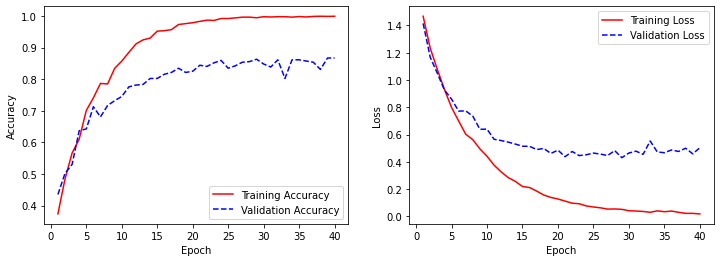

In [70]:
# Plot accuracy and loss
dict_hist_new_cnnmodel3 = history_new_modelcnn_3.history
iepoch = np.arange(1,41)
plot_acc(dict_hist_new_cnnmodel3, iepoch)

In [71]:
# Prediction on the test set
ytstpred_ncm3 = model_cnn3.predict(Xtst)
ytstcl_ncm3 = np.argmax(ytstpred_ncm3, axis=1)

In [72]:
accuracy_score(ytst, ytstcl_ncm3)

0.832572298325723

In [73]:
print(classification_report(ytst, ytstcl_ncm3, target_names=Cat_names))

              precision    recall  f1-score   support

      Glioma       0.84      0.74      0.79       186
  Meningioma       0.72      0.85      0.78       189
        None       0.90      0.71      0.79       102
   Pituitary       0.93      0.98      0.95       180

    accuracy                           0.83       657
   macro avg       0.85      0.82      0.83       657
weighted avg       0.84      0.83      0.83       657



In [74]:
# Attempt the fit with previously constructed model_cnndo1

history_new_modelcnndo1 = model_cnndo1.fit(Xtrn, ytrn_enc, validation_split=0.2, verbose=1,epochs=40, batch_size=256)

Epoch 1/40
9/9 [==============================] - 3s 193ms/step - loss: 1.5970 - accuracy: 0.3066 - val_loss: 1.4795 - val_accuracy: 0.1882
Epoch 2/40
9/9 [==============================] - 1s 143ms/step - loss: 1.3110 - accuracy: 0.3686 - val_loss: 1.7961 - val_accuracy: 0.2433
Epoch 3/40
9/9 [==============================] - 1s 143ms/step - loss: 1.2334 - accuracy: 0.4321 - val_loss: 1.7548 - val_accuracy: 0.2795
Epoch 4/40
9/9 [==============================] - 1s 142ms/step - loss: 1.1933 - accuracy: 0.4762 - val_loss: 1.8969 - val_accuracy: 0.3232
Epoch 5/40
9/9 [==============================] - 1s 141ms/step - loss: 1.1442 - accuracy: 0.5255 - val_loss: 2.0352 - val_accuracy: 0.3080
Epoch 6/40
9/9 [==============================] - 1s 142ms/step - loss: 1.0315 - accuracy: 0.5572 - val_loss: 2.4189 - val_accuracy: 0.3137
Epoch 7/40
9/9 [==============================] - 1s 142ms/step - loss: 0.9574 - accuracy: 0.5886 - val_loss: 2.4900 - val_accuracy: 0.4487
Epoch 8/40
9/9 [====

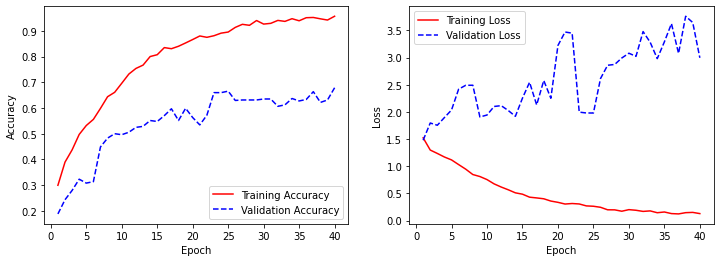

In [75]:
# Plot accuracy and loss
dict_hist_new_cnndo1 = history_new_modelcnndo1.history
iepoch = np.arange(1,41)
plot_acc(dict_hist_new_cnndo1, iepoch)

# This model will not be used, due to low validation accuracy

In [76]:
# Attempt the fit with previously constructed model_ln3

# Early stopping
earlystop = EarlyStopping(monitor='val_loss', patience=3)
history_new_modelln3 = model_ln3.fit(Xtrn, ytrn_enc, validation_split=0.2, 
                                     verbose=1, epochs=40, batch_size=256,
                                     callbacks=[earlystop])

Epoch 1/40
9/9 [==============================] - 1s 60ms/step - loss: 1.6910 - accuracy: 0.3022 - val_loss: 1.2639 - val_accuracy: 0.4506
Epoch 2/40
9/9 [==============================] - 0s 36ms/step - loss: 1.1931 - accuracy: 0.4774 - val_loss: 1.1365 - val_accuracy: 0.5627
Epoch 3/40
9/9 [==============================] - 0s 35ms/step - loss: 1.0113 - accuracy: 0.5743 - val_loss: 0.9202 - val_accuracy: 0.6312
Epoch 4/40
9/9 [==============================] - 0s 35ms/step - loss: 0.8177 - accuracy: 0.6615 - val_loss: 0.8696 - val_accuracy: 0.6293
Epoch 5/40
9/9 [==============================] - 0s 36ms/step - loss: 0.6895 - accuracy: 0.7178 - val_loss: 0.7971 - val_accuracy: 0.7072
Epoch 6/40
9/9 [==============================] - 0s 36ms/step - loss: 0.5599 - accuracy: 0.7620 - val_loss: 0.7079 - val_accuracy: 0.7243
Epoch 7/40
9/9 [==============================] - 0s 36ms/step - loss: 0.4319 - accuracy: 0.8333 - val_loss: 0.5600 - val_accuracy: 0.7947
Epoch 8/40
9/9 [===========

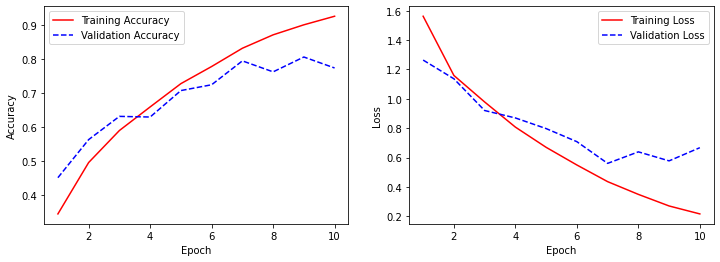

In [78]:
# Plot accuracy and loss
dict_hist_new_ln3 = history_new_modelln3.history
iepoch = np.arange(1,11)
plot_acc(dict_hist_new_ln3, iepoch)


In [79]:
# Prediction on test set

ytstpred_nln3 = model_ln3.predict(Xtst)
ytstcl_nln3 = np.argmax(ytstpred_nln3, axis=1)

In [80]:
# Classification report
print(classification_report(ytst, ytstcl_nln3, target_names=Cat_names))

              precision    recall  f1-score   support

      Glioma       0.79      0.86      0.82       186
  Meningioma       0.85      0.51      0.64       189
        None       0.69      0.86      0.77       102
   Pituitary       0.83      0.98      0.90       180

    accuracy                           0.79       657
   macro avg       0.79      0.80      0.78       657
weighted avg       0.80      0.79      0.78       657



[Text(0, 0.5, 'Glioma'),
 Text(0, 1.5, 'Meningioma'),
 Text(0, 2.5, 'None'),
 Text(0, 3.5, 'Pituitary')]

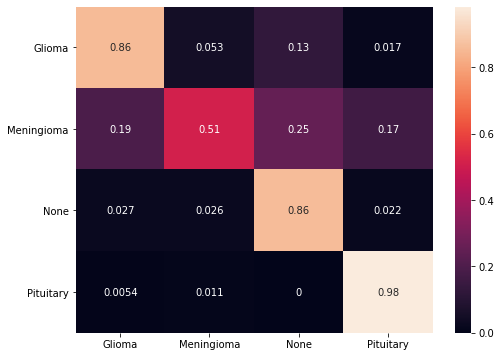

In [81]:
# Confusion matrix
cf_matrix = confusion_matrix(ytst, ytstcl_nln3)
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cf_matrix_n1, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)
ax.set_xticklabels(Cat_names)
ax.set_yticklabels(Cat_names)

Next, Keras Tuner will be attempted to improve the prediction.

### Keras Tuner ###

Keras Tuner will be used for the previously constructed LeNet-5-type model, with Bayesian optimization.

In [82]:
tuner_ln_new = BayesianOptimization(lnhmodel,
                                    objective='val_accuracy',
                                    max_trials=20,
                                    executions_per_trial=5,
                                    directory='.',
                                    project_name='capstone_lenet_new')

tuner_ln_new.search(Xtrn, ytrn_enc, validation_split=0.2, shuffle=True, verbose=1, epochs=20)

In [83]:
# Best model from Lenet-5-type architecture with keras tuner using Bayesian optimization
best_model_ln_new = tuner_ln_new.get_best_models(num_models=1)[0]
best_model_ln_new.evaluate(Xtst, ytst_enc)

21/21 [==============================] - 0s 5ms/step - loss: 0.9503 - accuracy: 0.8291


[0.8871965408325195, 0.8417047262191772]

In [84]:
# Test prediction
ypred_ktlnbo = best_model_ln_new.predict(Xtst)
ypredcl_ktlnbo = np.argmax(ypred_ktlnbo, axis=1) 

In [85]:
# Classification report
print(classification_report(ytst, ypredcl_ktlnbo, target_names=Cat_names))

              precision    recall  f1-score   support

      Glioma       0.85      0.76      0.80       186
  Meningioma       0.77      0.80      0.79       189
        None       0.85      0.82      0.84       102
   Pituitary       0.91      0.97      0.94       180

    accuracy                           0.84       657
   macro avg       0.84      0.84      0.84       657
weighted avg       0.84      0.84      0.84       657



[Text(0, 0.5, 'Glioma'),
 Text(0, 1.5, 'Meningioma'),
 Text(0, 2.5, 'None'),
 Text(0, 3.5, 'Pituitary')]

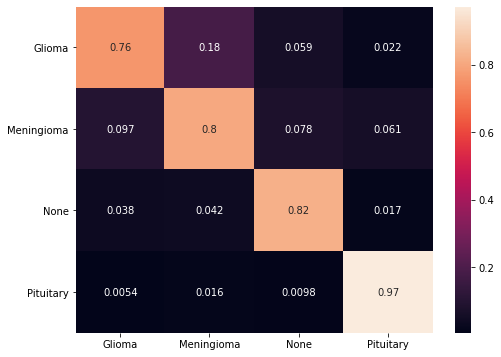

In [86]:
# Confusion matrix
cf_matrix = confusion_matrix(ytst, ypredcl_ktlnbo)
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cf_matrix_n1, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)
ax.set_xticklabels(Cat_names)
ax.set_yticklabels(Cat_names)

In [87]:
# Saving this model
best_model_ln_new.save("model_ktlnbo.h5")

In [88]:
best_model_ln_new.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 8)       80        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 150, 150, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 104)       7592      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 75, 75, 104)       0     

Next, the Keras Tuner for ResNet with Hyperband optimization is tried.

In [101]:
tuner_rn_new = Hyperband(hypermodel,
                         objective='val_accuracy',
                         max_epochs=20,
                         hyperband_iterations=1,
                         directory='.',
                         project_name='capstone_resnet_new'
                        )
          
tuner_rn_new.search(Xtrn, ytrn_enc, validation_split=0.2)

INFO:tensorflow:Reloading Oracle from existing project ./capstone_resnet_new/oracle.json
INFO:tensorflow:Reloading Tuner from ./capstone_resnet_new/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [102]:
# Best ResNet model
model_rn_new = tuner_rn_new.get_best_models(num_models=1)[0]
test_acc_model_rn_new = model_rn_new.evaluate(Xtst, ytst_enc)

21/21 [==============================] - 7s 40ms/step - loss: 0.4376 - accuracy: 0.8693


In [103]:
# Test prediction
ypred_ktrn = model_rn_new.predict(Xtst)
ypred_ktrn_classes = np.argmax(ypred_ktrn, axis=1)

In [104]:
# classification report
print(classification_report(ytst, ypred_ktrn_classes, target_names=Cat_names))

              precision    recall  f1-score   support

      Glioma       0.96      0.77      0.85       186
  Meningioma       0.82      0.85      0.84       189
        None       0.73      0.92      0.81       102
   Pituitary       0.94      0.96      0.95       180

    accuracy                           0.87       657
   macro avg       0.86      0.87      0.86       657
weighted avg       0.88      0.87      0.87       657



[Text(0, 0.5, 'Glioma'),
 Text(0, 1.5, 'Meningioma'),
 Text(0, 2.5, 'None'),
 Text(0, 3.5, 'Pituitary')]

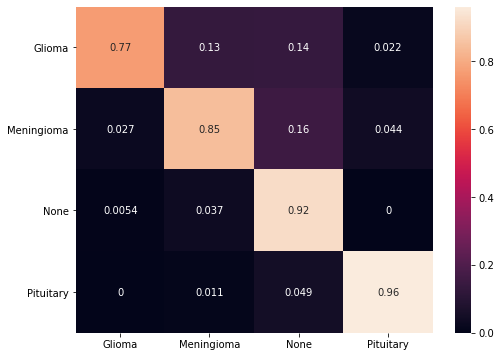

In [105]:
# Confusion matrix
cf_matrix = confusion_matrix(ytst, ypred_ktrn_classes)
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cf_matrix_n1, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)
ax.set_xticklabels(Cat_names)
ax.set_yticklabels(Cat_names)

In [107]:
# saving this model
model_rn_new.save("model_ktrn.h5")

In [106]:
model_rn_new.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   3136        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
_____________________________________________________________________________________________

### Conclusions: ###
The LeNet-5 model provided the highest recall for glioma here.

### Transfer learning with VGG-16 ###

Transfer learning with VGG-16 is tried here.

In [108]:
# Combine training and test sets with RGB channels, and split into new training, validation and test sets

Ximg_rgb = np.concatenate([Xtrain_rgb, Xtest_rgb], axis=0)
yclasses_fin = np.concatenate([ytrain_rgb, ytest_rgb], axis=0)

# training and test split
X1_new, Xtst_new, y1_new, ytst_new = train_test_split(Ximg_rgb, yclasses_fin, test_size=0.2, 
                                                      random_state=42, stratify=yclasses_fin)
# training and validation split
Xt_new, Xv_new, yt_new, yv_new = train_test_split(X1_new, y1_new, test_size=0.2, 
                                                  random_state=42, stratify=y1_new)

# one hot encoding of target variables
yt_new_enc = to_categorical(yt_new)
yv_new_enc = to_categorical(yv_new)
# Model(VGG model and classifier)
vgg_model, fmodel_new = build_vggmodel(inshape=Xt_new.shape[1:])
# Extract features
train_features_vgg_new = get_bottleneck_features(vgg_model, Xt_new)
val_features_vgg_new = get_bottleneck_features(vgg_model, Xv_new)
test_features_vgg_new = get_bottleneck_features(vgg_model, Xtst_new)



In [109]:
# Fit model to extracted features
history_fmodel_new = fmodel_new.fit(train_features_vgg_new, yt_new_enc, 
                                    validation_data=(val_features_vgg_new, yv_new_enc),
                                    batch_size=256,
                                    epochs=20,
                                    verbose=1)

Epoch 1/20
9/9 [==============================] - 1s 26ms/step - loss: 2.2133 - accuracy: 0.3085 - val_loss: 1.0828 - val_accuracy: 0.5760
Epoch 2/20
9/9 [==============================] - 0s 10ms/step - loss: 1.1102 - accuracy: 0.5164 - val_loss: 0.8464 - val_accuracy: 0.6483
Epoch 3/20
9/9 [==============================] - 0s 10ms/step - loss: 0.8202 - accuracy: 0.6732 - val_loss: 0.7304 - val_accuracy: 0.7034
Epoch 4/20
9/9 [==============================] - 0s 10ms/step - loss: 0.6614 - accuracy: 0.7433 - val_loss: 0.6165 - val_accuracy: 0.7548
Epoch 5/20
9/9 [==============================] - 0s 10ms/step - loss: 0.5776 - accuracy: 0.7844 - val_loss: 0.5529 - val_accuracy: 0.7757
Epoch 6/20
9/9 [==============================] - 0s 10ms/step - loss: 0.4661 - accuracy: 0.8318 - val_loss: 0.4887 - val_accuracy: 0.8042
Epoch 7/20
9/9 [==============================] - 0s 10ms/step - loss: 0.4137 - accuracy: 0.8496 - val_loss: 0.4489 - val_accuracy: 0.8270
Epoch 8/20
9/9 [===========

In [110]:
# Test prediction
ypred_vgg_new = fmodel_new.predict(test_features_vgg_new)
ypred_vgg_new_classes = np.argmax(ypred_vgg_new, axis=1)

In [111]:
# Classification report
print(classification_report(ytst_new, ypred_vgg_new_classes, target_names=Cat_names))

              precision    recall  f1-score   support

      Glioma       0.91      0.84      0.87       186
  Meningioma       0.84      0.89      0.87       189
        None       0.93      0.94      0.94       102
   Pituitary       0.96      0.96      0.96       180

    accuracy                           0.91       657
   macro avg       0.91      0.91      0.91       657
weighted avg       0.91      0.91      0.91       657



[Text(0, 0.5, 'Glioma'),
 Text(0, 1.5, 'Meningioma'),
 Text(0, 2.5, 'None'),
 Text(0, 3.5, 'Pituitary')]

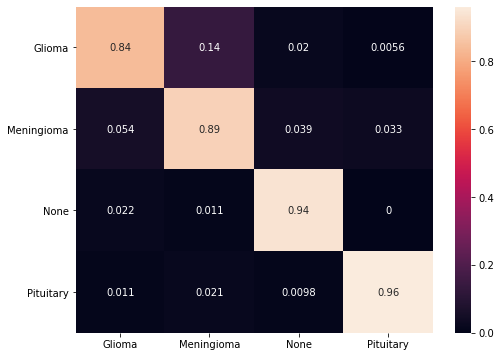

In [112]:
# Confusion matrix
cf_matrix = confusion_matrix(ytst, ypred_vgg_new_classes)
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cf_matrix_n1, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)
ax.set_xticklabels(Cat_names)
ax.set_yticklabels(Cat_names)

## Conclusions: ###
* Using the original training and test data sets, a maximum accuracy of 0.77 on the test set could be obtained, with a low recall of 0.22 for glioma. However, the validation accuracy is very high. This is caused by the difference in the types of glioma images in the training and test sets.
* Keras tuner with LeNet-5 and ResNet architectures, and AutoKeras with vanilla and ResNet architectures were attempted, but did not improve accuracy on the test set.
* When the training and test sets originally provided were combined and then split into train, validation and test sets, the prediction could be improved.